# IdeAlista

Study on the real estate market in Madrid.

For this study, we have gathered all the apartments listed on Idealista in December 2024 in the Community of Madrid, dividing them by areas for a total of 53 districts.

### What can we answer?
- How many properties are being sold/rented per district
- What risks and benefits would there be if I want to invest in an apartment
- With the money I have, which is the most suitable apartment to invest on


### Assumptions
The “updated time” on Idealista refers to how long the listing has been published.

### Missing
Non-payment index

### TODO:
- Make the notebook interactive when uploaded to github
- Add published data
- Divide data exploration in analysis per flat and analysis per district

In [1]:
import os
import re
import json
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

pd.set_option('display.float_format', '{:.3f}'.format)

/home/pdb/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
distritos = [i.split('_')[0] for i in os.listdir('data') if i.endswith('jsonl')]
distritos = list(set(distritos))

info = []
for distrito in distritos:    
    for k in ['venta', 'alquiler']:
        with open(f'data/{distrito}_{k}.jsonl', 'r') as f:
            for line in f:
                line = line.replace('null', 'None')
                line = eval(line)
                
                # Split details into hab, meters, floor and publish date                
                detail = line['details']
                hab = next((i for i in detail if 'hab.' in i), None)
                meters = next((i for i in detail if 'm²' in i), None)
                floor = next((i for i in detail if any(keyword in i for keyword in ['interior', 'exterior', 'ascensor'])), None)
                published = next((i for i in detail if any(keyword in i for keyword in ['horas', '\xa0'])), None)
                
                info.append({
                    'distrito': distrito,
                    'href': line['href'], 
                    'price': line['price'],
                    'meters': meters,
                    'hab': hab,
                    'floor': floor,
                    'published': published,
                    'parking': line['parking'], 
                    'state': k, 
                    'description': line['description']
                })
                
df = pd.DataFrame(info)
#df.to_csv('all_info.csv', index=False)
df.head()

distrito                  href     price  meters     hab  \
0  mostoles  /inmueble/105792148/  254.000€   98 m²  3 hab.   
1  mostoles  /inmueble/106359198/  505.000€  136 m²  3 hab.   
2  mostoles  /inmueble/106400857/  524.000€  137 m²  3 hab.   
3  mostoles  /inmueble/106359153/  560.000€  139 m²  3 hab.   
4  mostoles  /inmueble/101391314/  490.000€  149 m²  3 hab.   

                             floor published          parking  state  \
0  Planta 1ª exterior con ascensor      None             None  venta   
1                             None      None  Garaje incluido  venta   
2                             None      None  Garaje incluido  venta   
3                             None      None  Garaje incluido  venta   
4                             None      None  Garaje incluido  venta   

                                         description  
0  \n¡SOMOS PROPIETARIOS! Disfruta de todas las v...  
1  \nChalet Piloto\nEN CONSTRUCCIÓN.\nSituada en ...  
2  \nChalet Piloto\nEN CONSTRUCCIÓN.\nSituada en ...  
3  \nChalet Piloto\nEN CONSTRUCCIÓN.\nSituada en ...  
4  \n¿Estás listo para elevar tu estilo de vida c...

In [3]:
# Load advertised time per flat
published = {}
with open('advertisement_time.jsonl', 'r') as f:
    for line in f:
        line = eval(line)
        published[line['href']] = line['date']
        
temp = {
    'minuto': 1, 
    'minutos': 1, 
    'hora': 60, 
    'horas': 60, 
    'día': 60*24, 
    'días': 60*24, 
    'mes': 60*24*30, 
    'meses': 60*24*30, 
    'año': 60*24*30*12
}

for k, string in published.items():
    if string == 'Vendido':
        published[k] = 60*24*30
        continue
        
    integers = re.findall(r'\d+', string)
    integers = [int(num) for num in integers]
    integer = integers[0] if len(integers) else None
    if integer is None:
        for i in ['un', 'una']:
            if i in string:
                integer = 1
            
    metric = [t for t in temp if t in string][0]
    
    # Convert everything to minutes
    minutes = temp[metric] * integer
    published[k] = minutes + 60*24*30 

df['advertised_time'] = df['href'].apply(lambda x: published[x])

# Add number of flats per distrit
number_flats = []
with open('number_flats.jsonl', 'r') as f:
    for line in f:
        line = eval(line)
        numbers = re.findall(r"-?\d+(?:\.\d+)?", line['viviendas'])
        line['number_flats'] = numbers[0].replace('.', '')
        _idx = numbers.index('2')
        line['year'] = numbers[_idx+1:]
        line.pop('viviendas')
        number_flats.append(line)
number_flats = pd.DataFrame(number_flats)
number_flats = number_flats[['distrito', 'number_flats']].set_index('distrito')['number_flats'].to_dict()

In [4]:
# Transform data to float
df['price'] = df['price'].str.replace('.', '').str.replace('€', '').str.replace('/mes', '').astype(float)            
df['meters'] = df['meters'].str.replace('m²', '').str.replace('.', '').astype(float)


range_meters = {
    30: [0, 40],
    50: [40, 60], 
    80: [60, 90], 
    100: [90, 120], 
    120: [120, 1000]
}
def get_range_meters(meters):
    for r, _range in range_meters.items():
        if _range[0] <= meters < _range[1]:
            return r

df['mean_meters'] = df['meters'].apply(get_range_meters)
df['€/meter'] = df['price'] / df['meters']

# Group flats in range meters
df_grouped = df.groupby(['distrito', 'mean_meters', 'state']).agg({'€/meter': ['mean', 'size'], 'advertised_time': ['mean']}).reset_index()
df_grouped.columns = ['distrito', 'mean_meters', 'state', '€/meter', 'size', 'advertised_time']

data = df_grouped.pivot_table(
    index=['distrito', 'mean_meters'],
    columns='state',
    values=['€/meter', 'size', 'advertised_time']
).reset_index()

data.columns = ['distrito', 'mean_meters', 'advertised_rent', 'advertised_sell', 'size_rent', 'size_sell', '€/meter_rent', '€/meter_sell']
data.fillna(0, inplace=True)

data['number_flats'] = data['distrito'].apply(lambda x: int(number_flats[x]))


# Calculate metrics on average across each group of meters in each district
data['RB'] = data.apply(lambda x: ((x['€/meter_rent'] * 12) / x['€/meter_sell']) * 100 if x['€/meter_sell'] > 0 else 0, axis=1)
data['PER'] = data.apply(lambda x: x['€/meter_sell'] / (x['€/meter_rent'] * 12) if x['€/meter_rent'] > 0 else 0, axis=1)


evolution = pd.read_csv('evolution.csv')
data = pd.merge(data, evolution, on='distrito', how='inner')

data['sell'] = data['mean_meters'] * data['€/meter_sell']
data['rent'] = data['mean_meters'] * data['€/meter_rent']

data['change_2014_2024_sell'] = data['change_2014_2024_sell'].apply(lambda x: x/100)
data['change_2014_2024_rent'] = data['change_2014_2024_rent'].apply(lambda x: x/100)

data['change_2021_2024_sell'] = data['change_2021_2024_sell'].apply(lambda x: x/100)
data['change_2021_2024_rent'] = data['change_2021_2024_rent'].apply(lambda x: x/100)

# Revalorization: How much does the flats cost when I finish paying for it? Just took into account the inflation
data['revalorization'] = data['sell'] * (data['change_2021_2024_sell'] + 1 )**data['PER']

# Calculate PER adjusted to the rent price evolution
def calculate_per_adjusted(x):
    venta = x['sell']
    PER = x['PER']
    a0 = x['rent'] * 12
    g = x['change_2021_2024_sell']    
    n = math.log(1 + (g * venta / a0)) / math.log(1 + g) - 1 if a0 > 0 else 0 
    x['PER_adjusted'] = n
    return x

data = data.apply(calculate_per_adjusted, axis=1)

# Normalize the columns using Min-Max scaling
scaler = MinMaxScaler()
data['log_revalorization'] = np.log1p(data['revalorization'])  # Log transformation
data['normalized_revalorization'] = scaler.fit_transform(data[['log_revalorization']])

data['normalized_RB'] = scaler.fit_transform(data[['RB']])

data['inverse_PER'] = data['PER'].apply(lambda x: 1 / x if x > 0 else 0)
data['normalized_PER'] = scaler.fit_transform(data[['inverse_PER']])

In [5]:
data.head(10)

distrito  mean_meters  advertised_rent  advertised_sell  \
0  alcala-de-henares       30.000            0.000        52560.000   
1  alcala-de-henares       50.000        53768.571        89079.231   
2  alcala-de-henares       80.000        55657.021        94830.186   
3  alcala-de-henares      100.000        56677.143        97018.868   
4  alcala-de-henares      120.000        62485.000       100434.396   
5         alcobendas       30.000        49638.000       186520.000   
6         alcobendas       50.000        55800.000        57683.077   
7         alcobendas       80.000        69720.000        69480.000   
8         alcobendas      100.000        56289.231        62295.385   
9         alcobendas      120.000        65400.000        75058.500   

   size_rent  size_sell  €/meter_rent  €/meter_sell  number_flats     RB  ...  \
0      0.000      2.000         0.000      3164.286         81437  0.000  ...   
1      7.000     26.000        15.995      3397.737         81437  5.649  ...   
2     47.000    161.000        14.092      2465.718         81437  6.858  ...   
3     21.000    106.000        11.598      2630.324         81437  5.291  ...   
4     12.000    182.000         9.710      2309.539         81437  5.045  ...   
5     10.000      3.000        34.580      4133.142         33691 10.040  ...   
6      4.000     13.000        27.380      4276.594         33691  7.683  ...   
7     12.000     49.000        17.728      3124.692         33691  6.808  ...   
8     13.000     39.000        14.839      3021.621         33691  5.893  ...   
9     17.000     40.000        14.216      3615.300         33691  4.719  ...   

   change_2021_2024_rent       sell     rent  revalorization  PER_adjusted  \
0                  0.269  94928.571    0.000       94928.571         0.000   
1                  0.269 169886.864  799.757     4620769.622         7.215   
2                  0.269 197257.433 1127.320     2997208.476         6.418   
3                  0.269 263032.439 1159.804     8945197.197         7.492   
4                  0.269 277144.703 1165.259    11191915.005         7.695   
5                  0.244 123994.253 1037.386      443413.146         5.710   
6                  0.244 213829.702 1368.981     1130475.356         6.982   
7                  0.244 249975.372 1418.259     1636678.600         7.599   
8                  0.244 302162.128 1483.882     2648807.028         8.370   
9                  0.244 433835.995 1705.941     6528042.268         9.623   

   log_revalorization  normalized_revalorization  normalized_RB  inverse_PER  \
0              11.461                      0.495          0.000        0.000   
1              15.346                      0.663          0.419        0.056   
2              14.913                      0.644          0.509        0.069   
3              16.007                      0.692          0.393        0.053   
4              16.231                      0.701          0.375        0.050   
5              13.002                      0.562          0.746        0.100   
6              13.938                      0.602          0.570        0.077   
7              14.308                      0.618          0.506        0.068   
8              14.790                      0.639          0.438        0.059   
9              15.692                      0.678          0.350        0.047   

   normalized_PER  
0           0.000  
1           0.419  
2           0.509  
3           0.393  
4           0.375  
5           0.746  
6           0.570  
7           0.506  
8           0.438  
9           0.350  

[10 rows x 24 columns]

In [6]:
data.columns

Index(['distrito', 'mean_meters', 'advertised_rent', 'advertised_sell',
       'size_rent', 'size_sell', '€/meter_rent', '€/meter_sell',
       'number_flats', 'RB', 'PER', 'change_2014_2024_sell',
       'change_2014_2024_rent', 'change_2021_2024_sell',
       'change_2021_2024_rent', 'sell', 'rent', 'revalorization',
       'PER_adjusted', 'log_revalorization', 'normalized_revalorization',
       'normalized_RB', 'inverse_PER', 'normalized_PER'],
      dtype='object')

# With the money I have, which is the best district to invest on? 

Please give weights (together they should sum 1) to the variables according to what you value more

- PER number of years to get the return of investment
- Anual rental return
- Increase in property value. How much will the flat cost when I finish paying it?

In [109]:
input_money = 100000 

weight_valorizacion = 0.5
weight_rent_anual = 0.3
weight_per = 0.2
#weight_prestamo = 0.4

In [110]:
data['prestamo'] = data['venta'].apply(lambda x: x - input_money) # keep just the ones with 0 or positive prestamo

filtered = data[data['prestamo'] > 0].copy()
filtered['normalized_prestamo'] = scaler.fit_transform(1 / filtered[['prestamo']])
filtered['score'] = (
                       weight_rent_anual * filtered['normalized_RB'] 
                     + weight_valorizacion * filtered['normalized_revalorization'] 
                     + weight_per * filtered['normalized_PER']
                     #+ weight_prestamo * filtered['normalized_prestamo']
                    )
cols = ['distrito', 'number alquiler', 'number venta', 'meters_average', 'alquiler', 'venta', 'RB', 'PER', 'score', 'revalorization', 'prestamo']
filtered = filtered[cols]
filtered = filtered.sort_values(by=['prestamo'])
filtered.nlargest(20, 'score')

distrito  number alquiler  number venta  meters_average  \
45            carabanchel            23.00         21.00           30.00   
252  villaviciosa-de-odon             9.00          3.00           50.00   
232     villa-de-vallecas           190.00          7.00           30.00   
217                 usera            24.00          4.00           30.00   
46            carabanchel            49.00        104.00           50.00   
218                 usera            29.00         65.00           50.00   
5              alcobendas            10.00          3.00           30.00   
247            villaverde            42.00         73.00           50.00   
65          ciudad-lineal            14.00          7.00           30.00   
119                latina            27.00          6.00           30.00   
228             vicalvaro             6.00          6.00           50.00   
120                latina            31.00         28.00           50.00   
198                tetuan            79.00         56.00           30.00   
233     villa-de-vallecas            24.00         44.00           50.00   
170    puente-de-vallecas            45.00        230.00           80.00   
39    barrio-de-salamanca           418.00       1335.00          120.00   
213           tres-cantos             3.00          1.00           50.00   
209          torrelodones             1.00          3.00           80.00   
38    barrio-de-salamanca           235.00        310.00          100.00   
169    puente-de-vallecas            43.00        158.00           50.00   

     alquiler      venta    RB   PER  score  revalorization   prestamo  
45    1141.74  102666.99 13.35  7.49   0.78       589407.86    2666.99  
252   1167.13  104000.00 13.47  7.43   0.77       286837.52    4000.00  
232   1280.87  144582.14 10.63  9.41   0.69       768469.12   44582.14  
217   1191.37  143563.60  9.96 10.04   0.68      1511810.87   43563.60  
46    1226.77  150249.98  9.80 10.21   0.67      1623974.45   50249.98  
218   1295.42  166609.80  9.33 10.72   0.66      2055807.37   66609.80  
5     1037.39  123994.25 10.04  9.96   0.65       443413.15   23994.25  
247    949.72  121636.79  9.37 10.67   0.64       931423.34   21636.79  
65    1076.76  144492.00  8.94 11.18   0.64      1744949.84   44492.00  
119    964.24  130987.01  8.83 11.32   0.64      1491935.39   30987.01  
228   1224.61  173075.09  8.49 11.78   0.63      2165734.40   73075.09  
120   1164.75  164450.31  8.50 11.77   0.63      2061191.82   64450.31  
198   1160.99  167716.57  8.31 12.04   0.62      2227797.43   67716.57  
233   1128.62  156448.27  8.66 11.55   0.62      1217115.37   56448.27  
170   1405.98  211830.27  7.96 12.56   0.62      3698137.95  111830.27  
39    3668.81 1341267.76  3.28 30.47   0.62  11271546704.07 1241267.76  
213    998.06  142105.26  8.43 11.87   0.62      1261122.83   42105.26  
209   1348.84  207558.88  7.80 12.82   0.62      3547769.54  107558.88  
38    3060.02 1059790.40  3.46 28.86   0.61   5533728730.73  959790.40  
169   1014.36  157235.19  7.74 12.92   0.61      2981015.33   57235.19

# Plots

### Some plot functions

In [55]:
# Code

def plot_aux(aux, _type, title, log=False, height=800):
    fig = px.bar(aux, x="distrito", y=_type, color="mean_meters", color_continuous_scale='blues')
    layout_dict = {
        'width': 1100,
        'height': height,
        'xaxis': dict(categoryorder='total descending'),
        'yaxis': dict(title="Percentage", type='log') if log else None,
        'title': title,
        'legend_title_text': None,
        'barmode': 'group',
        'template': 'plotly_white'
    }
    fig.update_layout(**layout_dict)
    fig.show()

def plt_scatter(aux, x, y, title, xlabel=None, ylabel=None):
    fig = px.scatter(aux, x=x, y=y, color='distrito')
    layout_dict= {
        'template': 'plotly_white', 
        'title': title, 
        'xaxis_title': xlabel, 
        'yaxis_title': ylabel
    }
    fig.update_layout(**layout_dict)
    fig.show()

## Average square meters per district

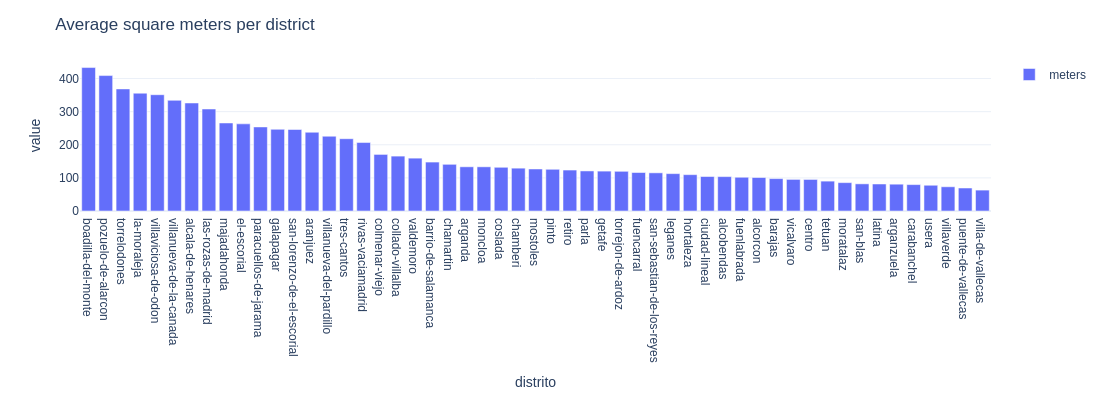

In [15]:
average_meters = df.groupby('distrito')['meters'].mean()
fig = px.bar(average_meters, color_continuous_scale=['blues'])
fig.update_layout(
    width=1100, 
    height=400,
    title="Average square meters per district",
    xaxis={'categoryorder': 'total descending'}, 
    legend_title_text=None,
    template='plotly_white')
fig.show()

## Percentage of selling/renting apartments per district

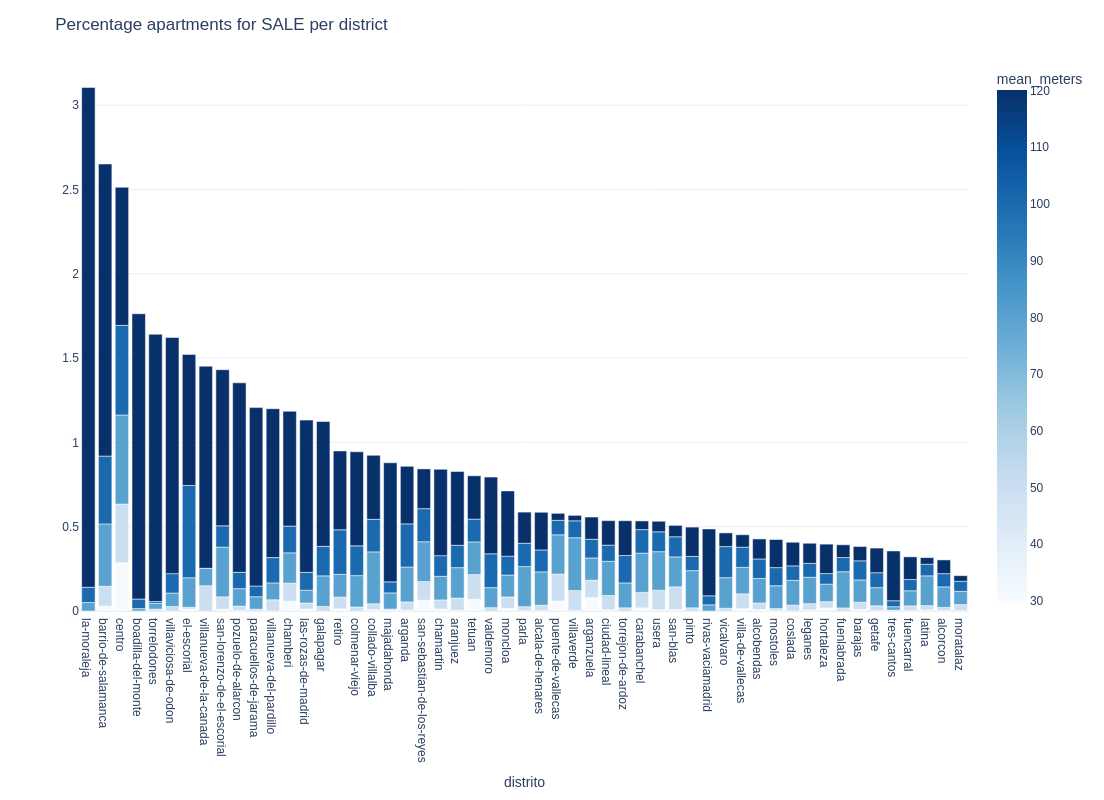

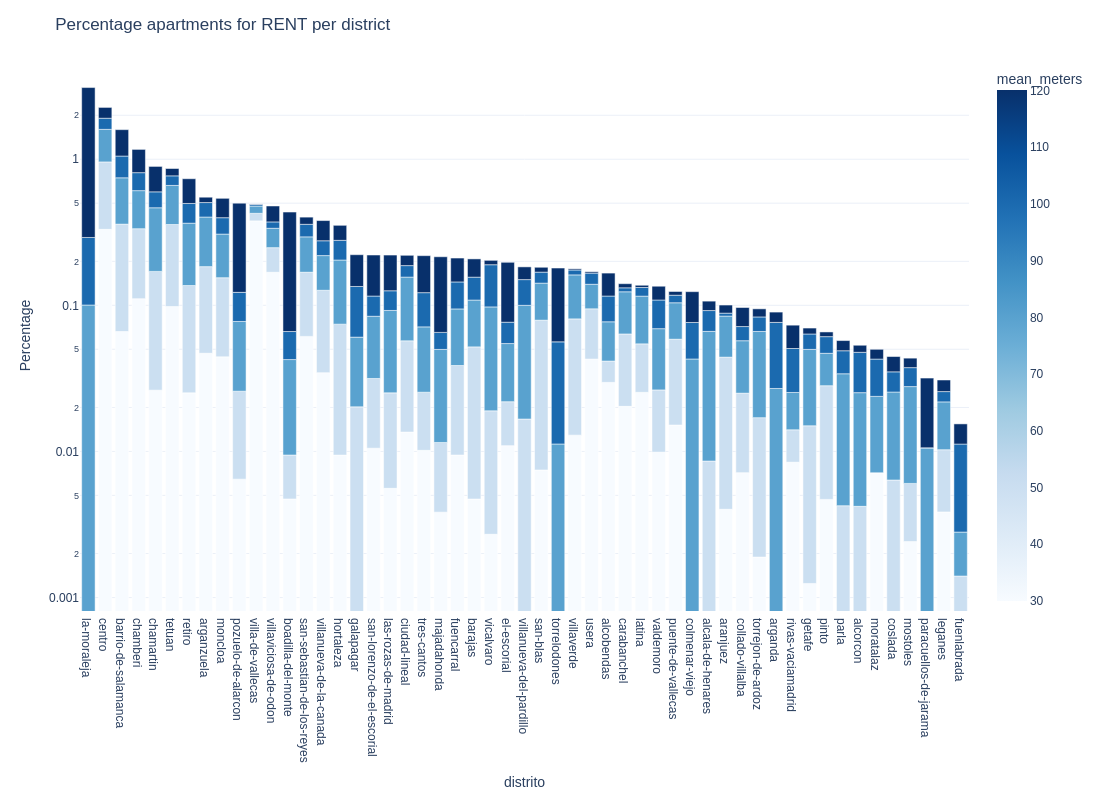

In [43]:
aux = data[['distrito', 'mean_meters', 'number_flats', 'size_sell', 'size_rent']].copy()

aux.loc[:, '%sell'] = (aux['size_sell'] / aux['number_flats']) * 100
aux.loc[:, '%rent'] = (aux['size_rent'] / aux['number_flats']) * 100

title = 'Percentage apartments for SALE per district'
plot_aux(aux, "%sell", title=title)
title = 'Percentage apartments for RENT per district'
plot_aux(aux, "%rent", title=title, log=True)

## Average price per square meter (€/m²)

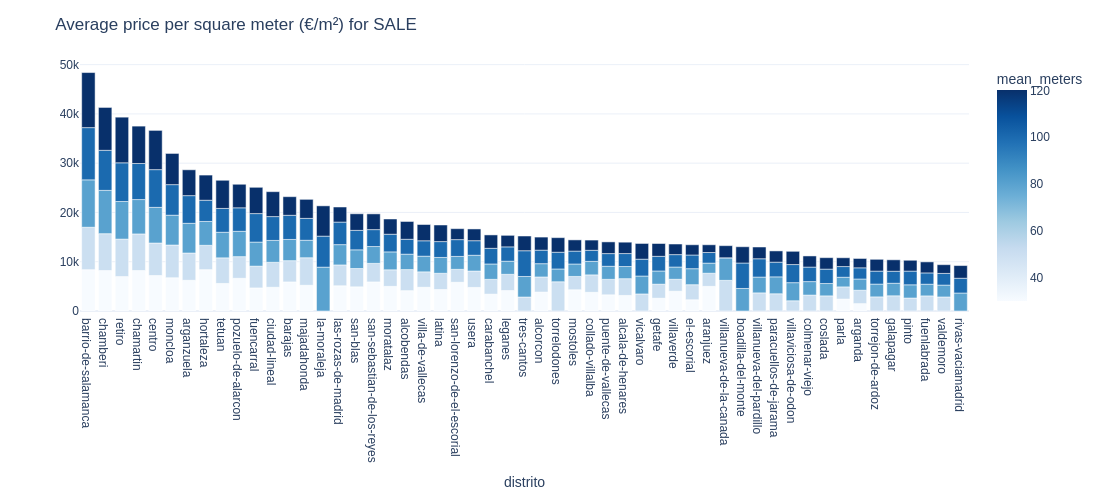

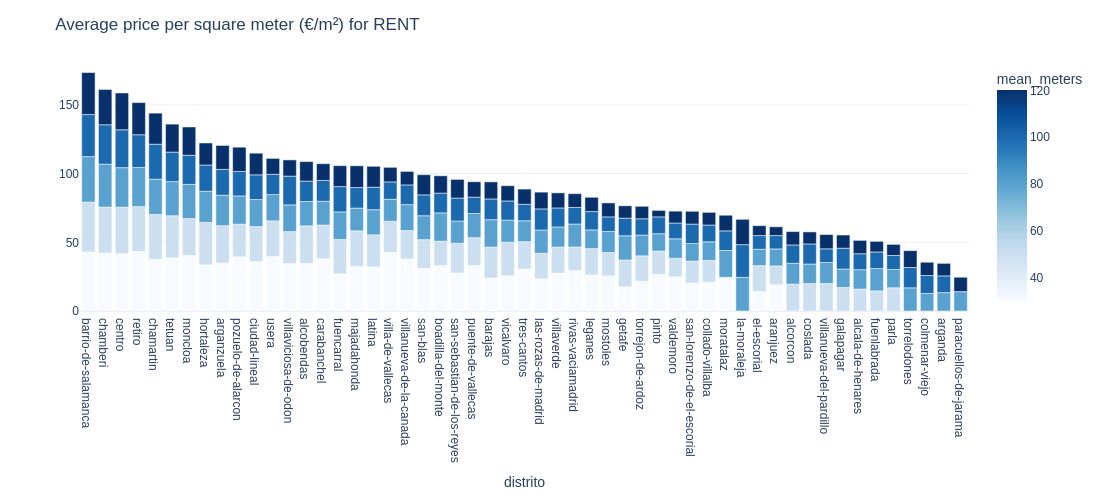

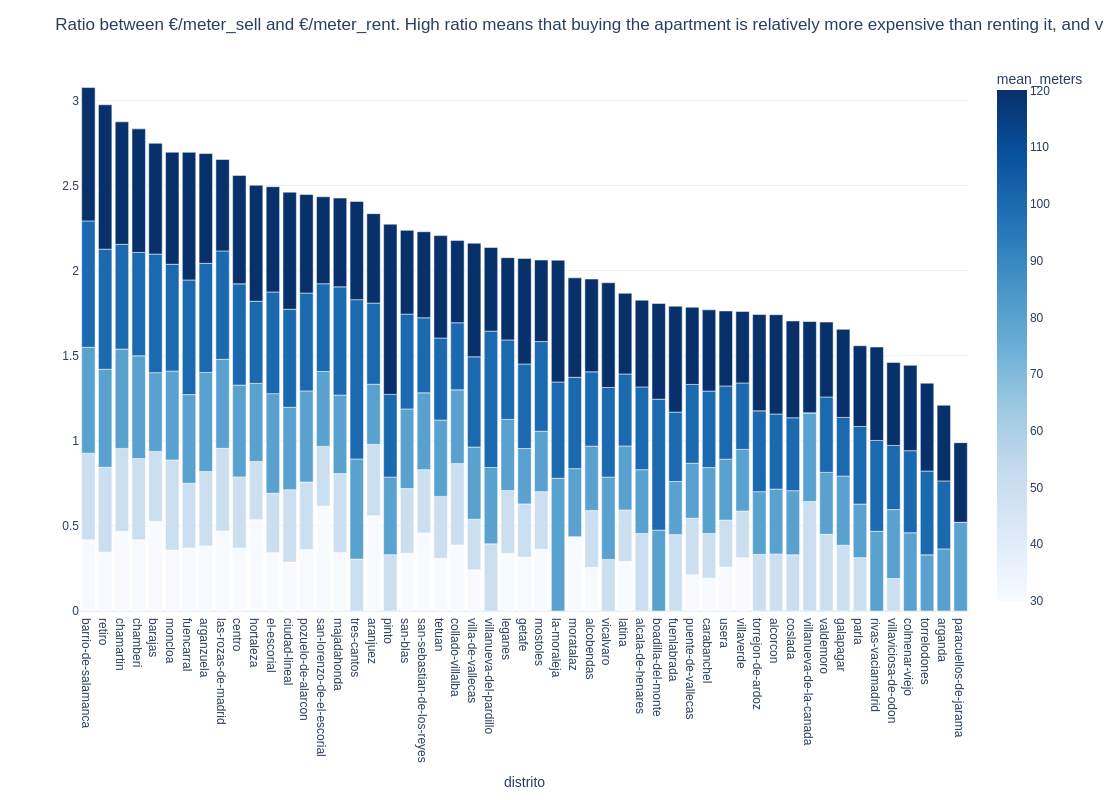

In [44]:
aux = data[['distrito', 'mean_meters', 'number_flats', '€/meter_rent', '€/meter_sell']].copy()

title = 'Average price per square meter (€/m²) for SALE'
plot_aux(aux, "€/meter_sell", title=title, height=500)

title = 'Average price per square meter (€/m²) for RENT'
plot_aux(aux, "€/meter_rent", title=title, height=500)


def calculate_ratio(x):
    return x['€/meter_sell'] / x['€/meter_rent'] if x['€/meter_rent'] > 0 else 0
aux['ratio'] = aux.apply(calculate_ratio, axis=1)
aux['norm_ratio'] = (aux['ratio'] - aux['ratio'].min()) / (aux['ratio'].max() - aux['ratio'].min())

title = 'Ratio between €/meter_sell and €/meter_rent. High ratio means that buying the apartment is relatively more expensive than renting it, and viceversa'
plot_aux(aux, 'norm_ratio', title=title)

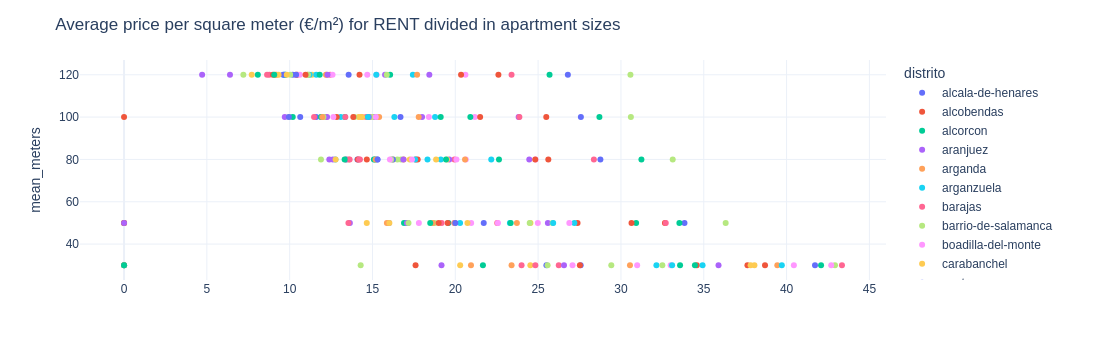

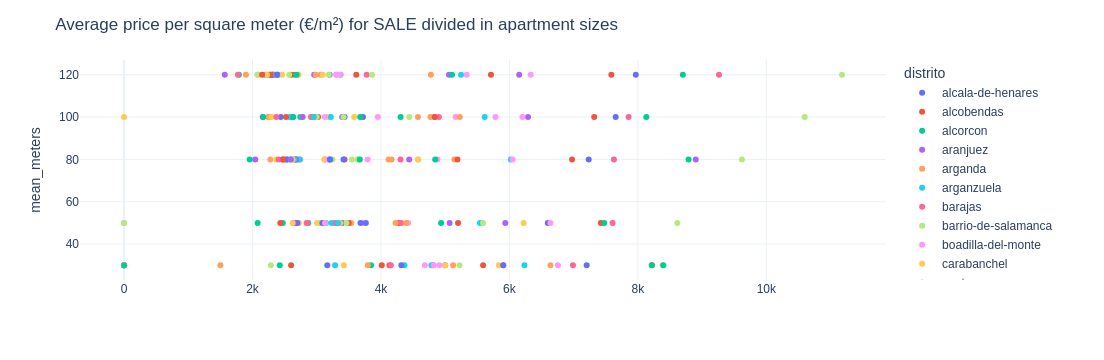

In [47]:
title = 'Average price per square meter (€/m²) for RENT divided in apartment sizes'
plt_scatter(data, x='€/meter_rent', y='mean_meters', title=title)
title = 'Average price per square meter (€/m²) for SALE divided in apartment sizes'
plt_scatter(data, x='€/meter_sell', y='mean_meters', title=title)

### Correlation between price and meters

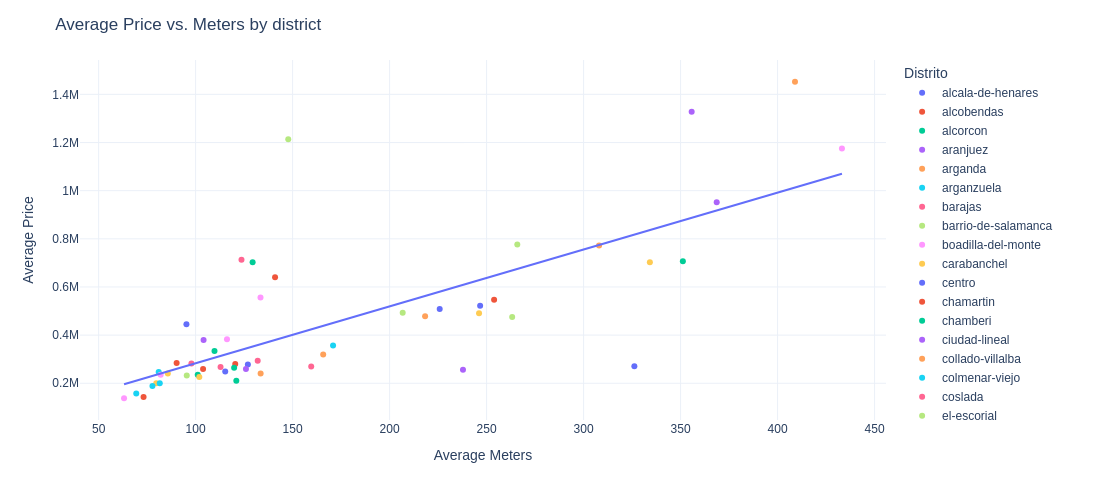

In [11]:
grouped = df.groupby('distrito').agg({'price': 'mean', 'meters': 'mean'}).reset_index()

slope, intercept = np.polyfit(grouped['meters'], grouped['price'], 1)
trend_x = np.linspace(grouped['meters'].min(), grouped['meters'].max(), 100)
trend_y = slope * trend_x + intercept

fig = px.scatter(grouped, x='meters', y='price', color='distrito')
fig.add_traces(px.line(x=trend_x, y=trend_y).data)
fig.update_layout(
    width=1000, 
    height=500,
    title='Average Price vs. Meters by district',
    xaxis_title='Average Meters',
    yaxis_title='Average Price',
    legend_title='Distrito',
    template='plotly_white'
)

## Average advertisement time

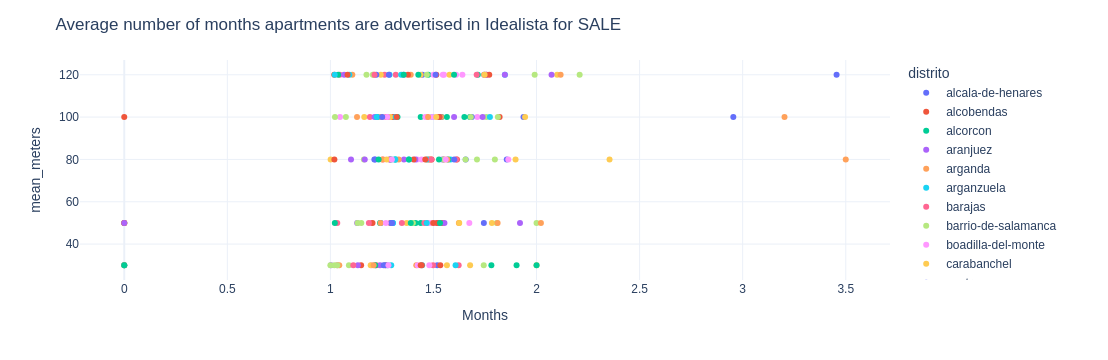

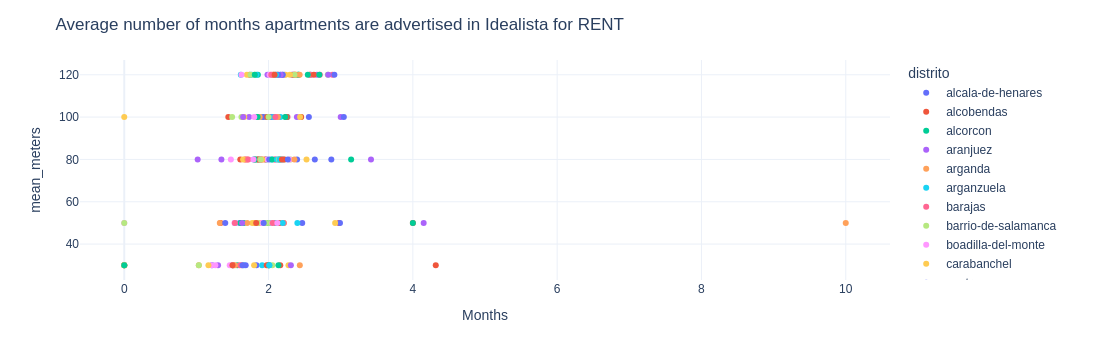

In [34]:
aux = data[['distrito', 'mean_meters', 'advertised_rent', 'advertised_sell']].copy()

aux['advertised_rent'] = aux['advertised_rent'].apply(lambda x: x / (60*24*30)) # Transform from minutes to months
aux['advertised_sell'] = aux['advertised_sell'].apply(lambda x: x / (60*24*30)) # Transform from minutes to months

title = 'Average number of months apartments are advertised in Idealista for SALE'
plt_scatter(aux, x='advertised_rent', y='mean_meters', title=title, xlabel='Months')
title = 'Average number of months apartments are advertised in Idealista for RENT'
plt_scatter(aux, x='advertised_sell', y='mean_meters', title=title, xlabel='Months')

### PER, PER adjusted and gross rental yield

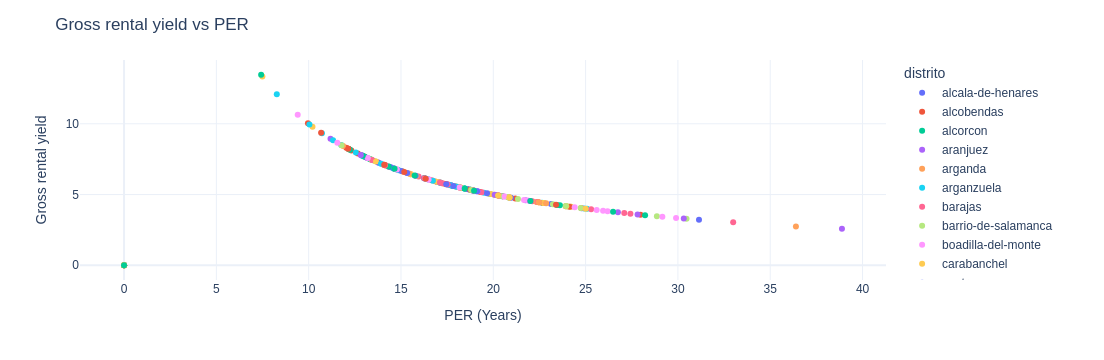

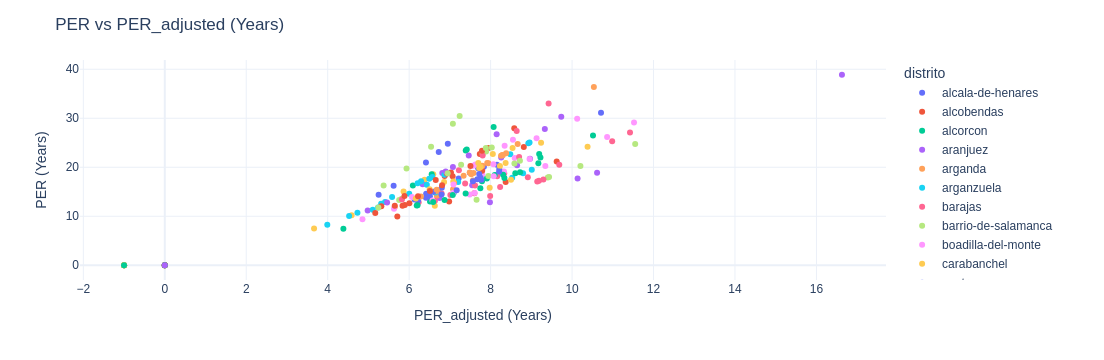

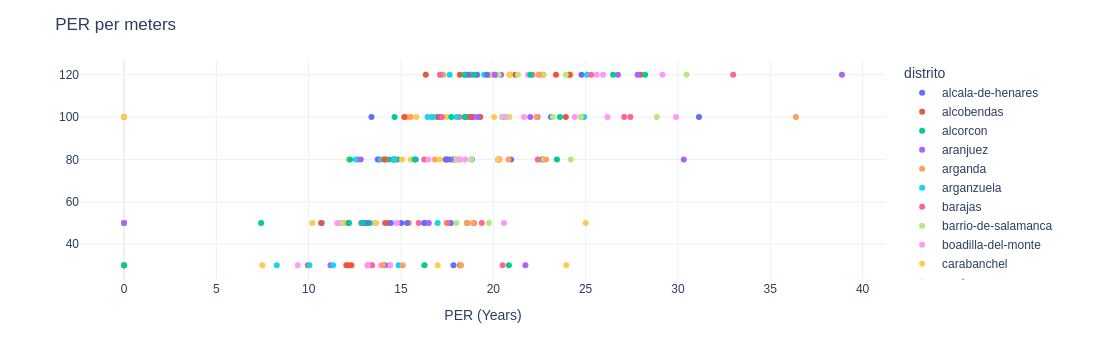

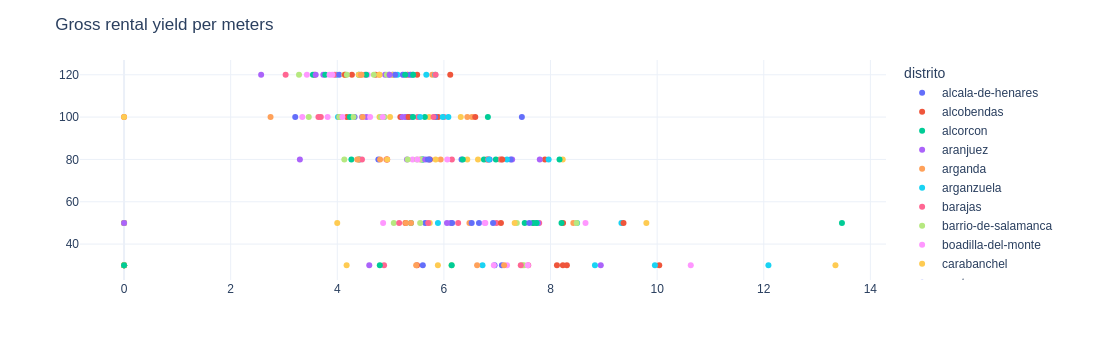

In [61]:
aux = data[['distrito', 'RB', 'PER', 'PER_adjusted', 'mean_meters']].copy()
title = 'Gross rental yield vs PER'
plt_scatter(aux, x='PER', y='RB', title=title, xlabel='PER (Years)', ylabel='Gross rental yield')

title = 'PER vs PER_adjusted (Years)'
plt_scatter(aux, x='PER_adjusted', y='PER', title=title, xlabel='PER_adjusted (Years)', ylabel='PER (Years)')

plt_scatter(aux, x='PER', y='mean_meters', title='PER per meters', xlabel='PER (Years)')
plt_scatter(aux, x='RB', y='mean_meters', title='Gross rental yield per meters', xlabel='')

## Compare change selling/renting rate 2014-2024

In [35]:
data.columns

Index(['distrito', 'mean_meters', 'advertised_rent', 'advertised_sell',
       'size_rent', 'size_sell', '€/meter_rent', '€/meter_sell',
       'number_flats', 'RB', 'PER', 'change_2014_2024_sell',
       'change_2014_2024_rent', 'change_2021_2024_sell',
       'change_2021_2024_rent', 'sell', 'rent', 'revalorization',
       'PER_adjusted', 'log_revalorization', 'normalized_revalorization',
       'normalized_RB', 'inverse_PER', 'normalized_PER'],
      dtype='object')

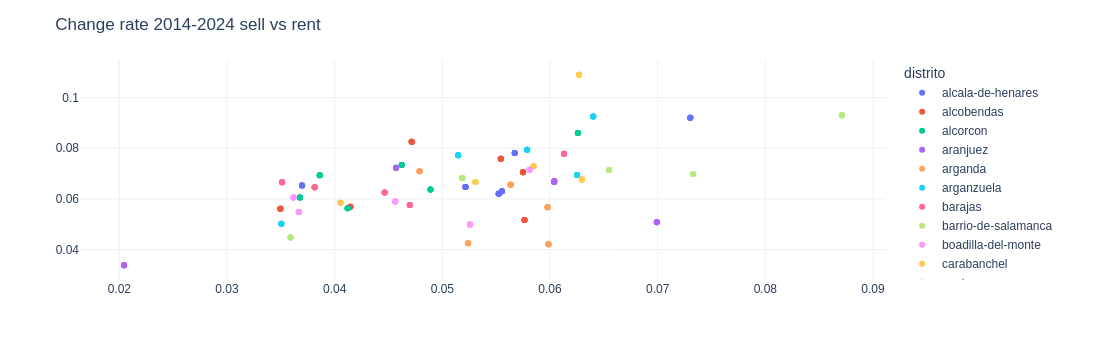

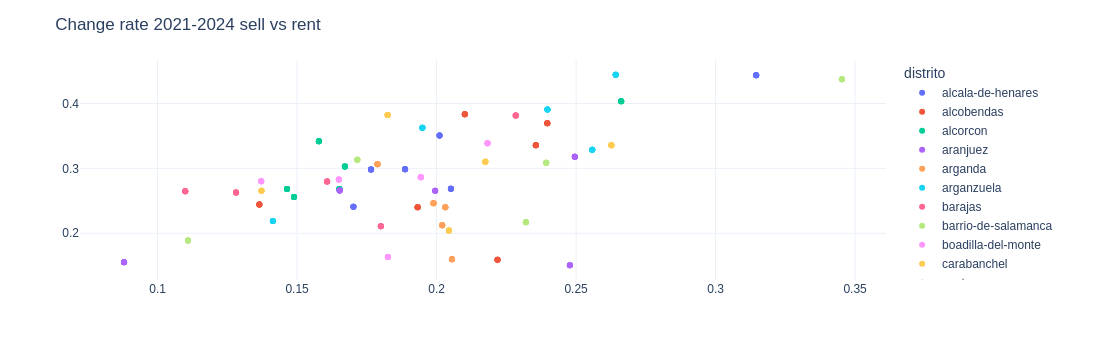

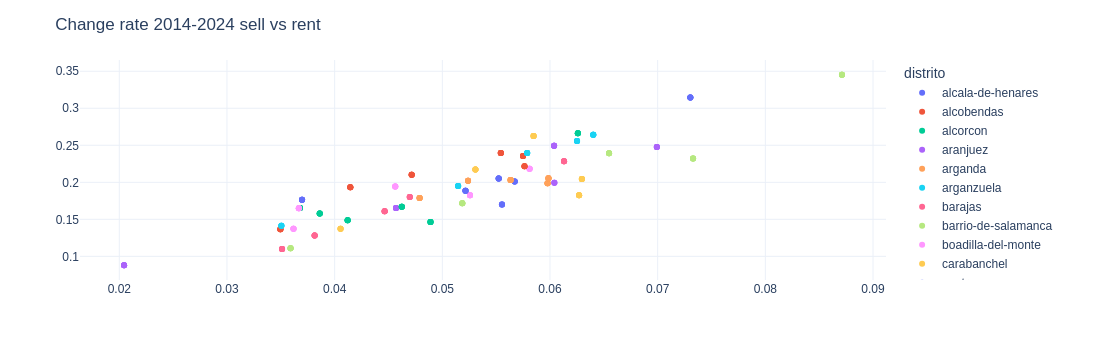

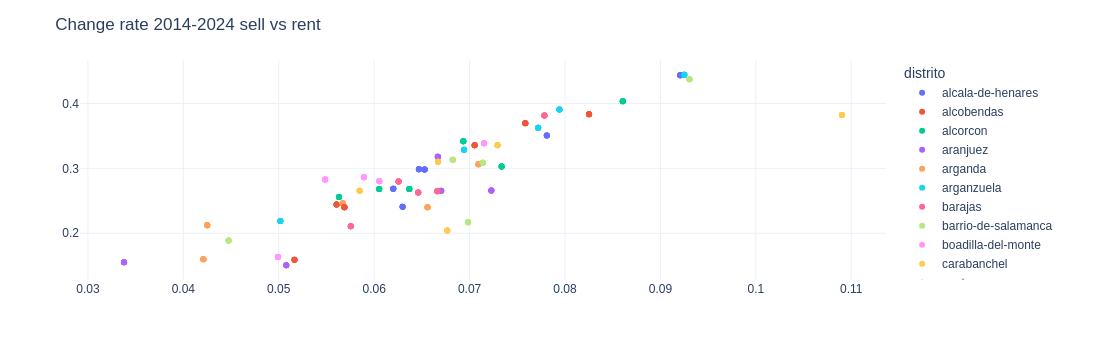

In [69]:
aux = data[['distrito', 'mean_meters', 'change_2014_2024_sell', 'change_2014_2024_rent', 'change_2021_2024_sell', 'change_2021_2024_rent']].copy()
plt_scatter(aux, x='change_2014_2024_sell', y='change_2014_2024_rent', title='Change rate 2014-2024 sell vs rent')
plt_scatter(aux, x='change_2021_2024_sell', y='change_2021_2024_rent', title='Change rate 2021-2024 sell vs rent')
plt_scatter(aux, x='change_2014_2024_sell', y='change_2021_2024_sell', title='Change rate 2014-2024 sell vs rent')
plt_scatter(aux, x='change_2014_2024_rent', y='change_2021_2024_rent', title='Change rate 2014-2024 sell vs rent')

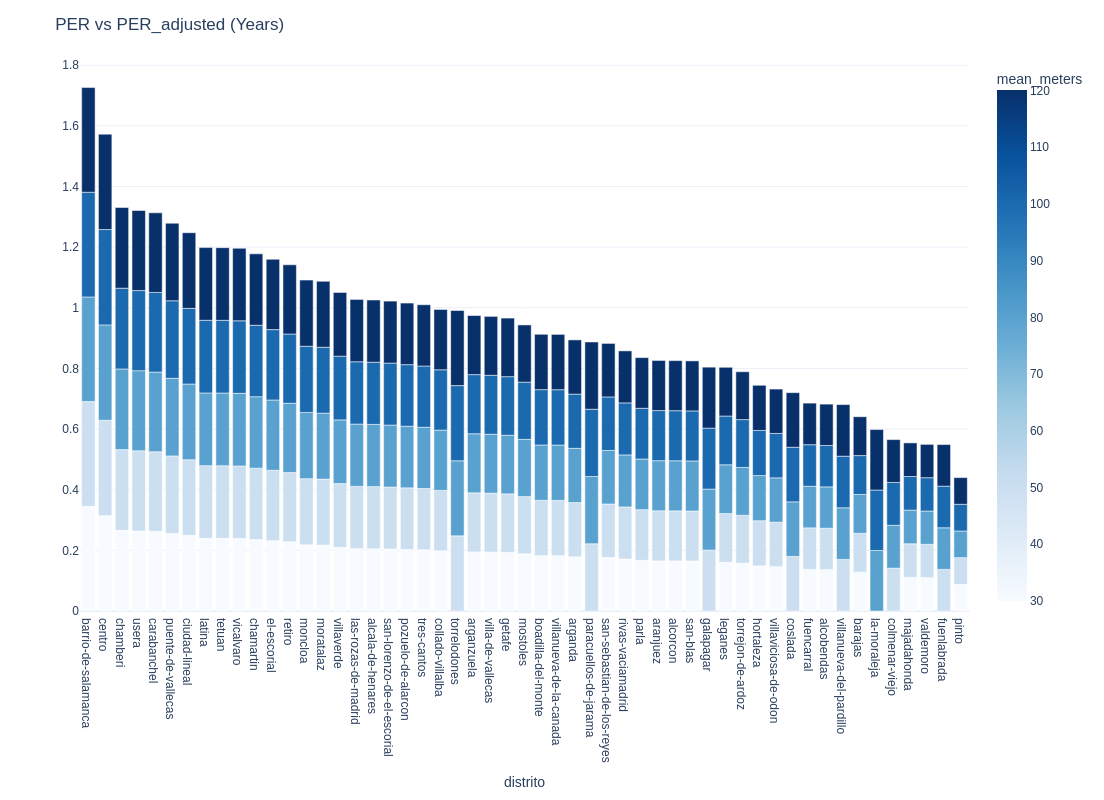

In [70]:
#plot_aux(aux, 'change_2021_2024_sell', title=title)

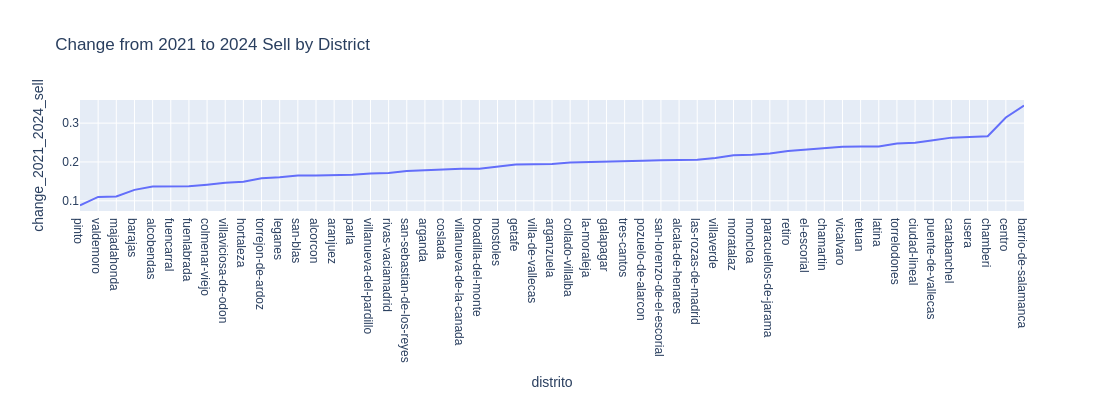

In [87]:
sorted_aux = aux.sort_values('change_2021_2024_sell')

fig = px.line(sorted_aux, x='distrito', y='change_2021_2024_sell',
              title='Change from 2021 to 2024 Sell by District')
fig.update_layout(
    height=400
)
fig.show()

### Compare change selling/renting rate 2021-2024

### PER and RB

# Old

In [ ]:
cols = ['href', 'distrito','price', 'meters', 'hab', 'floor', 'published', 'state']
df = df[cols]

fig, ax = plt.subplots(figsize=(17, 5))
grouped = df.groupby(['distrito', 'state']).size().unstack(fill_value=0).reset_index()
grouped['number_flats'] = grouped['distrito'].apply(lambda x: int(number_flats[x]))
grouped['% alquiler'] = (grouped['alquiler'] / grouped['number_flats']) * 100
grouped['% venta'] = (grouped['venta'] / grouped['number_flats']) * 100

grouped[['distrito', '% alquiler', '% venta']].plot(kind='bar', ax=ax, width=0.8)
ax.grid(True, axis='y', linestyle='--', linewidth=0.5)
ax.set_ylabel('%')
ax.set_xticklabels(grouped['distrito'])
plt.title('Number of flats to sell/rent in each district, compared to the total number of flats en each district')
plt.show()

df['price'] = df['price'].str.replace('.', '').str.replace('€', '').str.replace('/mes', '').astype(float)
average_price = df.groupby('distrito')['price'].mean()
fig, ax = plt.subplots(figsize=(17, 5))
average_price.plot(kind='bar', stacked=True, ax=ax)
ax.grid(True, axis='y', linestyle='--', linewidth=0.5)
ax.set_ylabel('€')
plt.title('Average sell price per district')
plt.show()

df['meters'] = df['meters'].str.replace('m²', '').str.replace('.', '').astype(float)
average_meters = df.groupby('distrito')['meters'].mean()
fig, ax = plt.subplots(figsize=(17, 5))
average_meters.plot(kind='bar', stacked=True, ax=ax)
ax.grid(True, axis='y', linestyle='--', linewidth=0.5)
ax.set_ylabel('m^2')
plt.title('Average square meters per district')
plt.show()

0.7503750582443206 correlation between price and meters


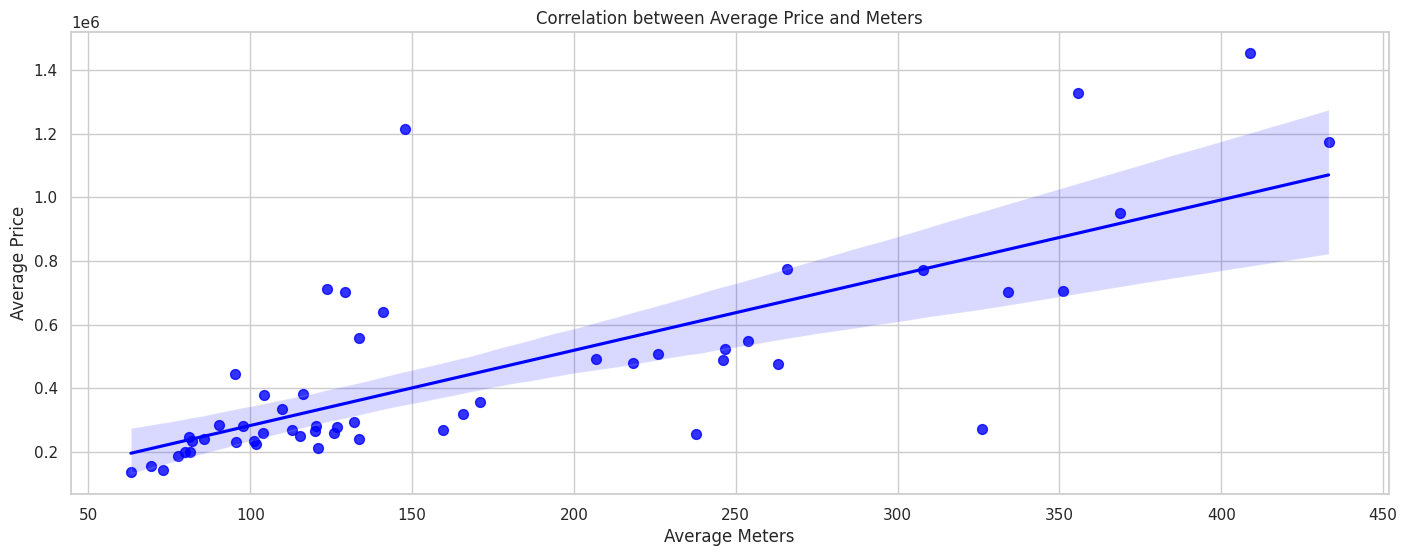

In [13]:
grouped = df.groupby('distrito').agg({'price': 'mean', 'meters': 'mean'})
correlation = grouped['price'].corr(grouped['meters'])
print(correlation, 'correlation between price and meters')

sns.set(style='whitegrid')
plt.figure(figsize=(17, 6))
sns.regplot(data=grouped, x='meters', y='price', scatter_kws={'s': 50}, color='blue')

plt.title('Correlation between Average Price and Meters')
plt.xlabel('Average Meters')
plt.ylabel('Average Price')
plt.show()

# Group each distrit in 
- 20-40 m^2
- 40-60 m^2
- 60-90 m^2
- 90-120 m^2
- /> 120 m^2

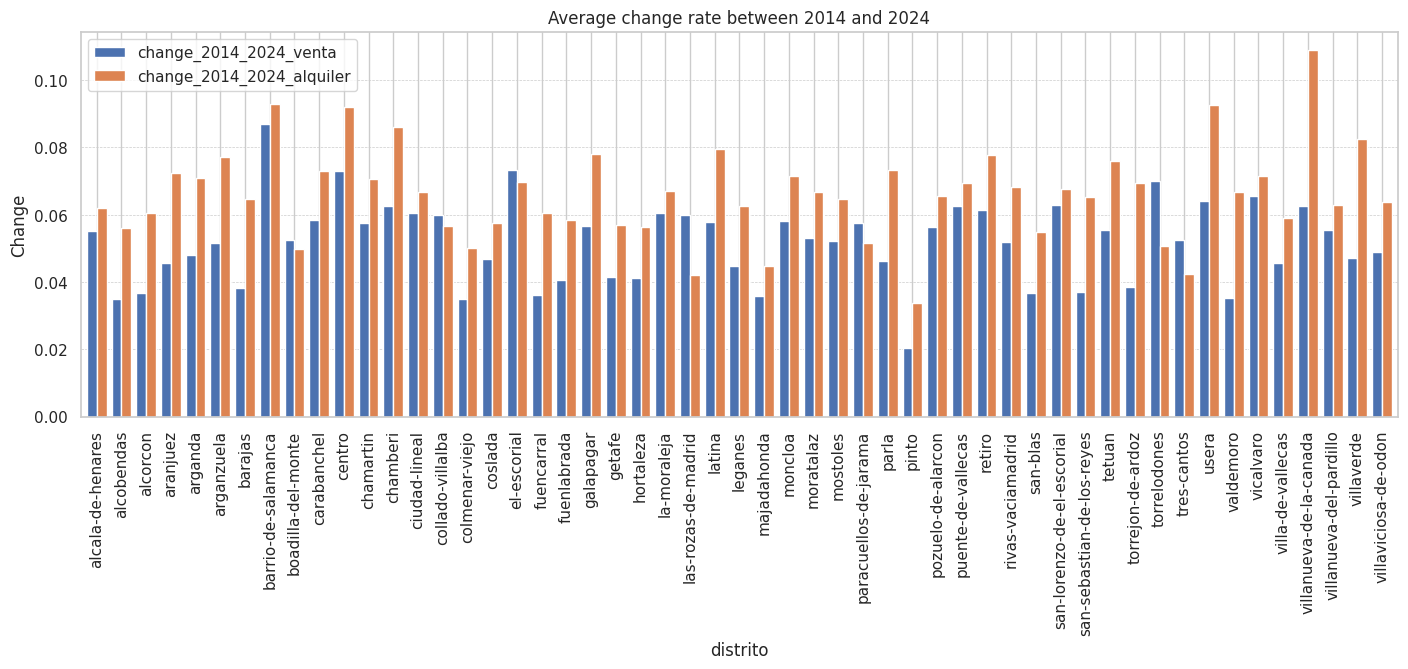

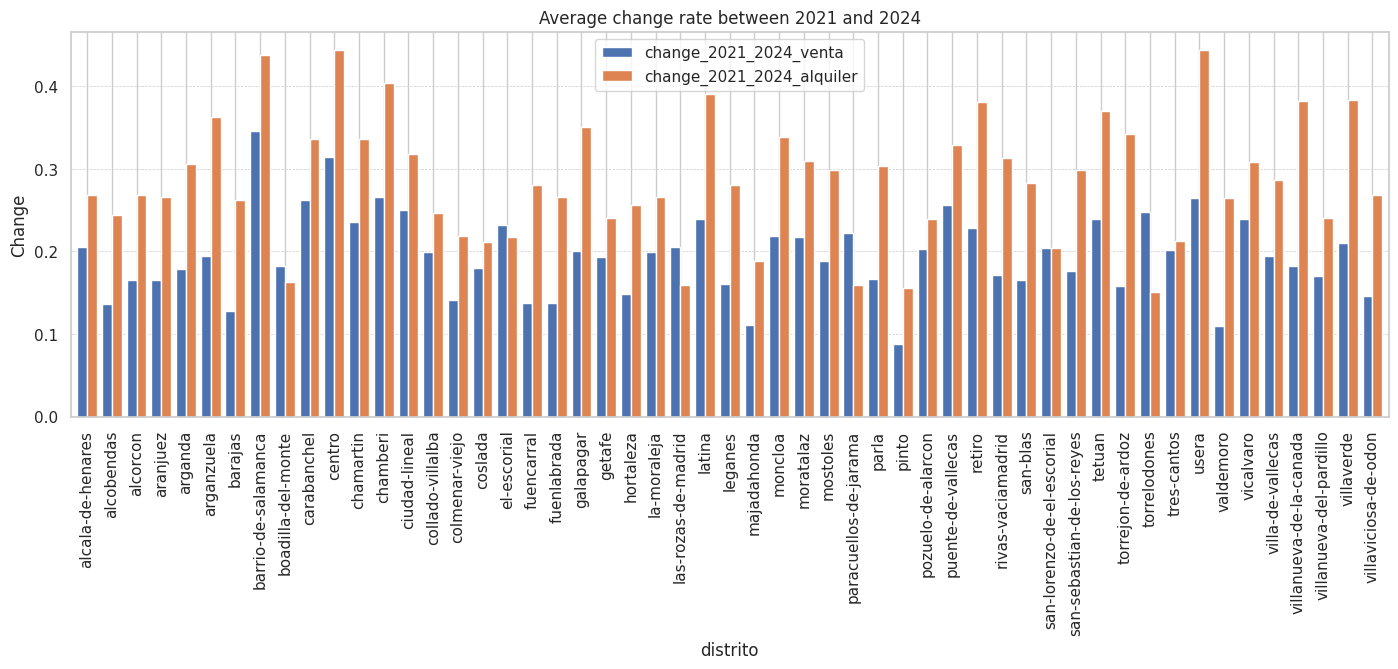

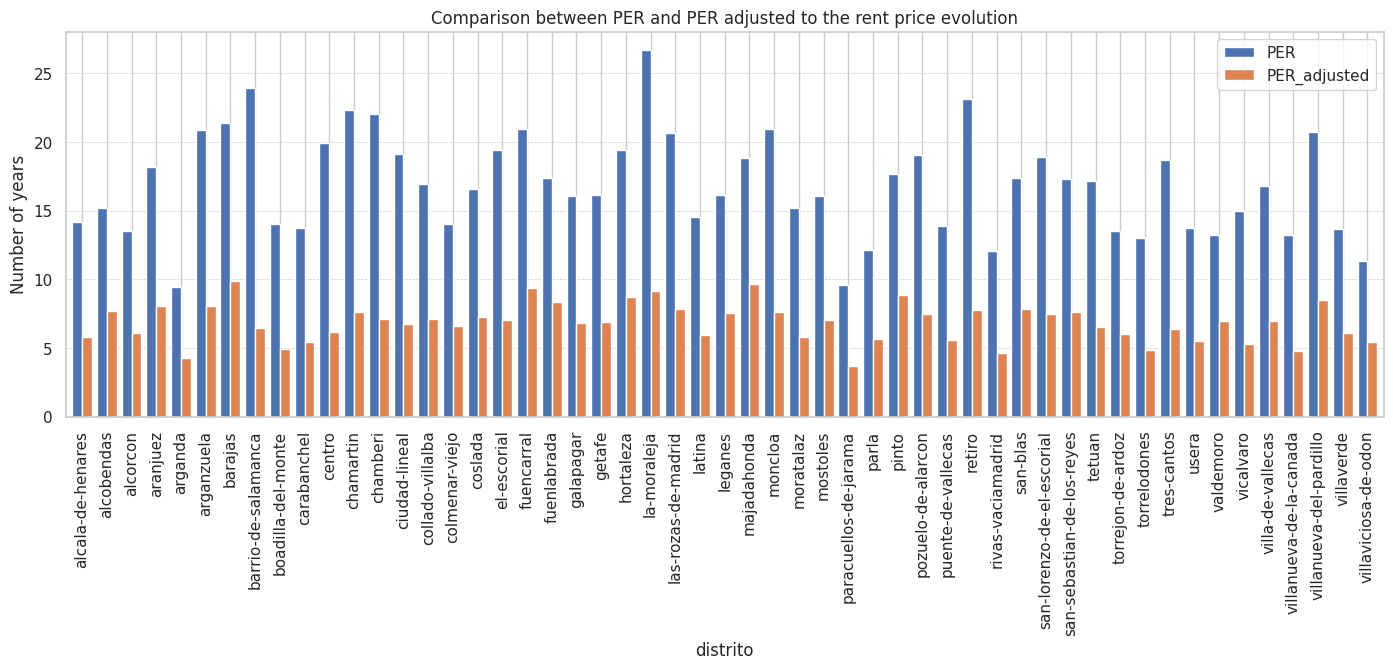

In [24]:
range_meters = {
    0: [0, 40],
    1: [40, 60], 
    2: [60, 90], 
    3: [90, 120], 
    4: [120, 1000]
}
def get_range_meters(meters):
    for r, _range in range_meters.items():
        if _range[0] <= meters < _range[1]:
            return r
df['range_meters'] = df['meters'].apply(get_range_meters)
df['€/meter'] = df['price'] / df['meters']

df_grouped = df.groupby(['distrito', 'range_meters', 'state']).agg({'€/meter': ['mean', 'size']}).reset_index()
df_grouped.columns = ['distrito', 'range_meters', 'state', '€/meter', 'size']

data = df_grouped.pivot_table(
    index=['distrito', 'range_meters'],
    columns='state',
    values=['€/meter', 'size']
).reset_index()
data.columns = ['distrito', 'range_meters', 'number alquiler', 'number venta', '€/meter alquiler', '€/meter venta']
data.fillna(0, inplace=True)

data['RB'] = data.apply(lambda x: ((x['€/meter alquiler'] * 12) / x['€/meter venta']) * 100 if x['€/meter venta'] > 0 else 0, axis=1)
data['PER'] = data.apply(lambda x: x['€/meter venta'] / (x['€/meter alquiler'] * 12) if x['€/meter alquiler'] > 0 else 0, axis=1)

evolution = pd.read_csv('evolution.csv')
data = pd.merge(data, evolution, on='distrito', how='inner')

range_meters_average = {
    0: 30,
    1: 50, 
    2: 80, 
    3: 100, 
    4: 120
}

data['meters_average'] = data['range_meters'].apply(lambda x: range_meters_average[x])
data = data.drop(columns=['range_meters'])
data['venta'] = data['meters_average'] * data['€/meter venta']
data['alquiler'] = data['meters_average'] * data['€/meter alquiler']

data['change_2014_2024_venta'] = data['change_2014_2024_venta'].apply(lambda x: x/100)
data['change_2014_2024_alquiler'] = data['change_2014_2024_alquiler'].apply(lambda x: x/100)

data['change_2021_2024_venta'] = data['change_2021_2024_venta'].apply(lambda x: x/100)
data['change_2021_2024_alquiler'] = data['change_2021_2024_alquiler'].apply(lambda x: x/100)

# Revalorization: How much does the flats cost when I finish paying for it? Just took into account the inflation
data['revalorization'] = data['venta'] * (data['change_2021_2024_venta'] + 1 )**data['PER']

# Calcular PER ajustado a la evolucion del alquiler
def calculate_per_adjusted(x):
    venta = x['venta']
    PER = x['PER']
    a0 = x['alquiler'] * 12
    g = x['change_2021_2024_venta']    
    n = math.log(1 + (g * venta / a0)) / math.log(1 + g) - 1 if a0 > 0 else 0 
    x['PER_adjusted'] = n
    return x

data = data.apply(calculate_per_adjusted, axis=1)

# Normalize the columns using Min-Max scaling
scaler = MinMaxScaler()
data['normalized_revalorization'] = scaler.fit_transform(data[['revalorization']])
data['normalized_RB'] = scaler.fit_transform(data[['RB']])
data['inverse_PER'] = data['PER'].apply(lambda x: 1 / x if x > 0 else 0)
data['normalized_PER'] = scaler.fit_transform(data[['inverse_PER']])


def plot_comparison_two_variables(data, variable1, variable2, title, y_name):
    aux = data[['distrito', variable1, variable2]]
    fig, ax = plt.subplots(figsize=(17, 5))
    aux.groupby('distrito').mean().plot(kind='bar', ax=ax, width=0.8)
    ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5)
    ax.set_ylabel(y_name)
    plt.title(title)
    plt.show()


# Plots
title = 'Average change rate between 2014 and 2024'
y_name = 'Change'
plot_comparison_two_variables(data, 'change_2014_2024_venta', 'change_2014_2024_alquiler', title, y_name)

title = 'Average change rate between 2021 and 2024'
y_name = 'Change'
plot_comparison_two_variables(data, 'change_2021_2024_venta', 'change_2021_2024_alquiler', title, y_name)

title = 'Comparison between PER and PER adjusted to the rent price evolution'
y_name = 'Number of years'
plot_comparison_two_variables(data, 'PER', 'PER_adjusted', title, y_name)

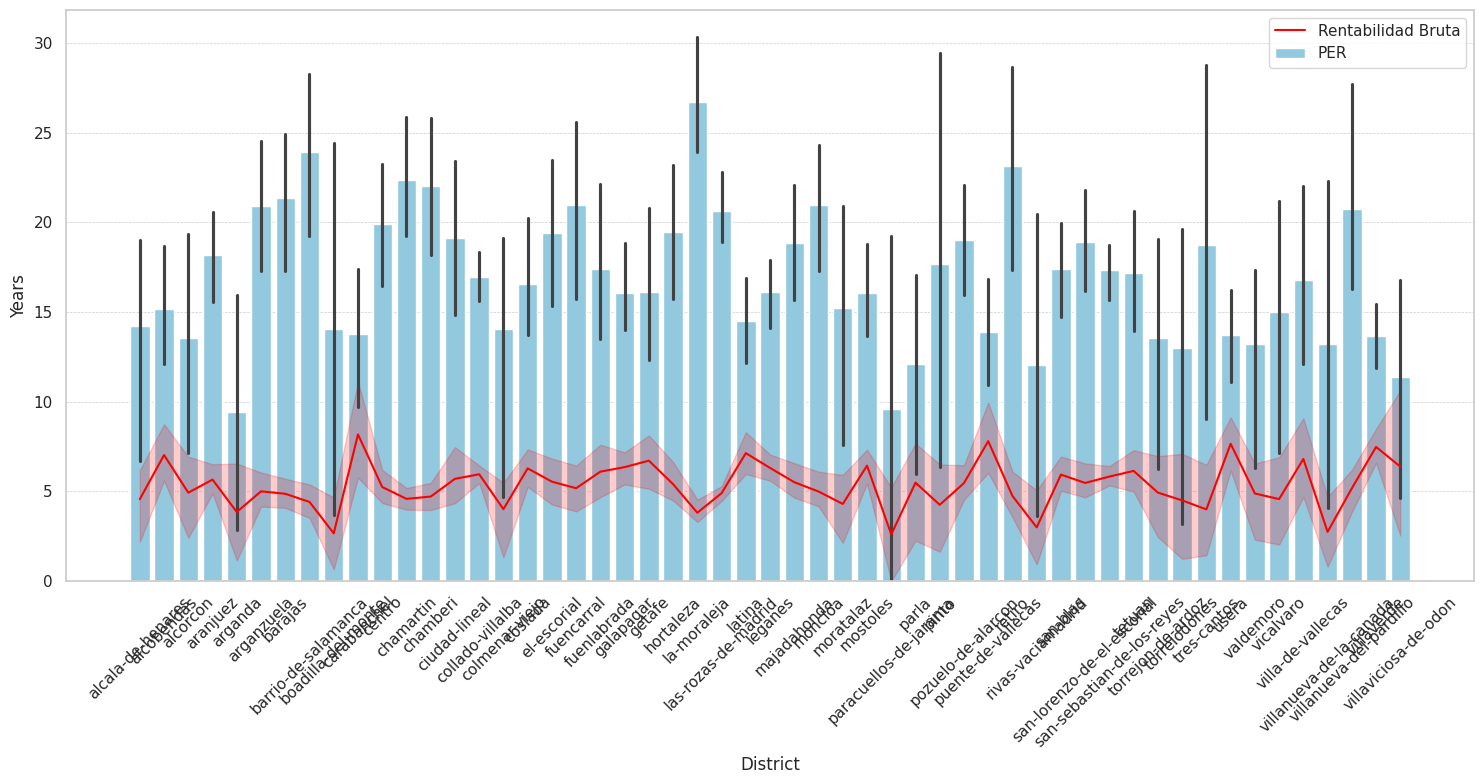

In [15]:
fig, ax = plt.subplots(figsize=(15, 8))

sns.barplot(data=data, x=data['distrito'], y='PER', ax=ax, color='skyblue', label='PER')
sns.lineplot(data=data, x=data['distrito'], y='RB', ax=ax, color='red', label='Rentabilidad Bruta')
ax.set_xlabel('District')
ax.set_ylabel('Years')
ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5)
ax.tick_params(axis='x', rotation=45)
fig.tight_layout()
ax.legend()
plt.show()

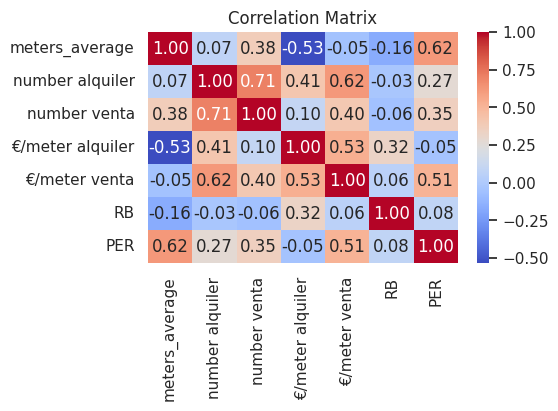

In [16]:
correlation_matrix = data[['meters_average', 'number alquiler', 'number venta', '€/meter alquiler', '€/meter venta', 'RB', 'PER']].corr()

plt.figure(figsize=(5, 3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [23]:
data = data.set_index('distrito')
# Save the dataframe used to upload to gpt
data.to_csv('final_table.csv')